# Collecting Pageviews and Redirects using [WikiToolkit](https://github.com/pgilders/WikiToolkit/tree/main)

* `get_links` - for collecting different types of links from a list of pages. 
This can be used to collect in-, out-, interwiki-, lang-, and external links to/from a list of articles. **We use to collect lang links!**  
* `api_article_views` - for collecting daily/monthly pageviews data from the API for a list of articles.  
* `pipeline_api_article_views` - A convenience wrapper function that, in addition to the above, also sets up client/session and redirect maps.  
This function sets up the session/client, fixes redirects with PageMaps, and collects pageview data. It is a convenience function that wraps the previous function. Note that this does not require manual setup of the `wtsession`. Observe that the figures are slightly higher than the previous example, due to the inclusion of pageviews for the redirects.

# Setup

## Installs and Imports

In [3]:
!pip install mwapi
!pip install mwviews
!pip install wikitoolkit

In [4]:
import wikitoolkit
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

## Agent, Session, and Function for data collection

In [5]:
my_agent = 'mwapi ICWSM collection <EMAIL>'
wtsession = wikitoolkit.WTSession('en.wikipedia', user_agent=my_agent)

In [6]:
# Create dataframe with list of pages and languages
async def create_df_lang (wtsession, list_articles, languages=None):
    # Colect links to all the languages of a Wiki article in English
    langlinks = await wikitoolkit.get_links(wtsession, mode=['lang'],
                                     titles=list_articles)
    
    df = pd.concat({k: pd.DataFrame(v).T for k, v in langlinks.items()}
                         ).reset_index().rename(columns={'level_0': 'source',
                                                         'level_1': 'target_lang',
                                                         0: 'target_title'})
    if languages:
        df = df.loc[df["target_lang"].isin(languages)]

    # including an entry for English (used for my initial query)
    new_rows_en = [(s, "en", s) for s in df["source"].unique()]
    new_df_en = pd.DataFrame(new_rows_en, columns=df.columns)

    df = pd.concat([df, new_df_en], ignore_index=True)
    df.reset_index(inplace=True, drop=True)

    return df

# Create dataframe with list of pages, languages and daily views+redirects from agent* during start* to end*
async def create_df_views(df_lang, 
                          aav_args={'agent':'user', 'start':'20150701','end':'20250701'}, 
                          redirect=True):

    all_pageviews = []
    
    for title_eng, lang_wiki, title_wiki in tqdm(df_lang.itertuples(index=False), total=len(df_lang)):
        if redirect:
            pageviews_p, pagemaps = await wikitoolkit.pipeline_api_article_views(lang_wiki+'.wikipedia', 
                                                                                 my_agent, title_wiki, 
                                                                                 aav_args=aav_args)
        else:
            pageviews_p = await wikitoolkit.api_article_views(wtsession, 
                                                              lang_wiki+'.wikipedia', 
                                                              title_wiki, 
                                                              agent=aav_args["agent"], 
                                                              start=aav_args["start"], 
                                                              end=aav_args["end"])
            
        if pageviews_p:  # Make sure there's data
            df_pv = pd.DataFrame(pageviews_p)
            df_pv['source'] = title_eng
            df_pv['target_lang'] = lang_wiki
            df_pv['target_title'] = title_wiki
            all_pageviews.append(df_pv)
    
    # Combine all into a single DataFrame
    df_all_pageviews = pd.concat(all_pageviews, ignore_index=True)
    df_all_pageviews.columns = [pd.to_datetime(c).strftime('%Y-%m-%d') if isinstance(c, (pd.Timestamp, str)) and ' ' in str(c) else str(c) for c in df_all_pageviews.columns]

    df_all_pageviews = df_lang.merge(df_all_pageviews)
    df_all_pageviews.rename(columns={"source": "Source", "target_lang": "Language", "target_title": "Title"}, inplace=True)

    return df_all_pageviews


# Create one dataframe per city and save as a csv 
def split_city_files(df, output_dir):
    # Group by city and save each group to a separate CSV
    for city, group in df.groupby("Source"):
        filename = f"{output_dir}/{city}.csv"
        group.to_csv(filename, index=False)


## Page names

In [7]:
european_capitals = ["Amsterdam", "Andorra la Vella", "Athens", "Baku", "Belfast", "Belgrade", "Berlin", "Bern", "Bratislava", "Brussels", "Bucharest", "Budapest", "Cardiff", "Chișinău", "Copenhagen", "Dublin", "Edinburgh", "Helsinki", "Kyiv", "Lisbon", "Ljubljana", "London", "Luxembourg City", "Madrid", "Minsk", "Monaco", "Moscow", "Nuuk", "Oslo", "Paris", "Podgorica", "Prague", "Pristina", "Reykjavík", "Riga", "Rome", "City of San Marino", "Sarajevo", "Skopje", "Sofia", "Stockholm", "Sukhumi", "Tallinn", "Tbilisi", "Tirana", "Tórshavn", "Vaduz", "Valletta", "Vienna", "Vilnius", "Warsaw", "Zagreb", "Nicosia", "Gibraltar", "Ankara", "Vatican City"]

polish_cities = ["Białystok", "Bydgoszcz", "Częstochowa", "Gdańsk", "Gdynia", "Gliwice", "Katowice", "Kielce", "Kraków", "Łódź", "Lublin", "Poznań", "Radom", "Rzeszów", "Sosnowiec", "Szczecin", "Toruń", "Warsaw", "Wrocław"]

lithuanian_cities = ["Alytus", "Kaunas", "Klaipėda", "Marijampolė", "Panevėžys", "Šiauliai", "Tauragė", "Telšiai", "Utena, Lithuania", "Vilnius"]

german_cities = ["Berlin", "Hamburg", "Munich", "Cologne", "Frankfurt", "Stuttgart", "Düsseldorf", "Leipzig", "Dortmund", "Essen", "Bremen", "Dresden", "Hanover", "Nuremberg", "Duisburg", "Bochum", "Wuppertal", "Bielefeld", "Bonn", "Münster", "Mannheim", "Karlsruhe", "Augsburg", "Wiesbaden", "Mönchengladbach", "Gelsenkirchen", "Aachen", "Braunschweig", "Chemnitz", "Kiel", "Halle (Saale)", "Magdeburg", "Freiburg im Breisgau", "Krefeld", "Mainz", "Lübeck", "Erfurt", "Oberhausen", "Rostock", "Kassel"]

world_cities = ["Beijing", "Jakarta", "Kinshasa", "Lima", "Tokyo"]

# Data collection
**Languages we are interested in** + top languages according to Wikipedia readership: English, Japanese, Russian, Spanish, German, French, Italian, Chinese, Persian, Portuguese, Polish, Arabic, Turkish, Indonesian, Dutch

In [8]:
languages_wikipedia_basic = ["en", "pl", "ru", "uk", "lt", "de"]
languages_wikipedia_top = languages_wikipedia_basic + ["ja", "es", "fr", "it", "zh", "fa", "pt", "ar", "tr", "id", "nl"]

In [9]:
folder_names = ["WORLD", "EU", "PL", "LT", "DE"]
lists_names = [world_cities, european_capitals, polish_cities, lithuanian_cities, german_cities]

In [ ]:
for folder, list_cities in zip(folder_names, lists_names):
    print(folder)
    
    list_articles = list_cities
    
    # Create output directory if it doesn't exist
    output_dir = 'data_cities_' + folder
    os.makedirs(output_dir, exist_ok=True)

    # Filter languages we are interested in only
    df_lang = await create_df_lang (wtsession, list_articles, languages=languages_wikipedia_top)
    # Collect views and redirects
    df_all_pageviews = await create_df_views(df_lang)
    # Save files
    split_city_files(df_all_pageviews, output_dir)

# Comparison views and views+redirects for Polish cities

## Data collection

In [10]:
list_articles = polish_cities
languages_pl = ["en", "pl", "ru", "uk"]

# Filter languages we are interested in only
df_lang = await create_df_lang (wtsession, list_articles, languages=languages_pl)

Getting lang-links


In [ ]:
df_all_pageviews_with_redirect = await create_df_views(df_lang, redirect=True)
df_all_pageviews_with_redirect.head(5)

In [ ]:
df_all_pageviews_only = await create_df_views(df_lang, redirect=False)
df_all_pageviews_only.head(5)

## Comparison and plot

In [13]:
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14


def compute_redirect_share_yearly(df_only, df_with_redirects):
    """Compute yearly redirect share for each page-language pair.
    Aggregate to yearly totals before computing shares.
    """
    # Align on Source, Language, Title
    df_only = df_only.drop(columns="Title").set_index(["Source", "Language"])
    df_with_redirects = df_with_redirects.drop(columns="Title").set_index(["Source", "Language"])
    
    # Keep only date columns
    date_cols = df_only.columns
    df_only = df_only[date_cols]
    df_with_redirects = df_with_redirects[date_cols]
    
    # Convert wide → long
    df_only_long = df_only.reset_index().melt(
        id_vars=["Source", "Language"],
        var_name="date", value_name="views_only"
    )
    df_with_redirects_long = df_with_redirects.reset_index().melt(
        id_vars=["Source", "Language"],
        var_name="date", value_name="views_with_redirects"
    )
    
    # Merge
    df = pd.merge(
        df_only_long, df_with_redirects_long,
        on=["Source", "Language", "date"]
    )
    
    # Convert date → year
    df["date"] = pd.to_datetime(df["date"])
    df["Year"] = df["date"].dt.year
    
    # Drop date before grouping
    df = df.drop(columns="date")
    
    # Aggregate yearly totals
    df_yearly = df.groupby(["Source", "Language", "Year"], as_index=False).sum()
    
    # Compute redirect share (%)
    df_yearly["Percentage of redirects"] = (
        (df_yearly["views_with_redirects"] - df_yearly["views_only"]) /
        df_yearly["views_with_redirects"]
    ) * 100
    
    return df_yearly


def plot_redirect_share_by_year_language(df_yearly):
    """Boxplot of redirect share per year, grouped by language."""

    lang_map = {"en": "English",
                "uk": "Ukrainian",
                "pl": "Polish",
                "ru": "Russian"}
    
    colors_dict = {"English": "#666666", 
                   "Ukrainian": "#e7298a",
                   "Polish": "#d95f02",
                   "Russian": "#1b9e77"}

    PROPS = {'boxprops':{'facecolor':'white', 'edgecolor':'black'}, 
             'medianprops':{'color':'black'},
             'whiskerprops':{'color':'black'},
             'capprops':{'color':'black'}}

    # map codes → names
    df_yearly["Language"] = df_yearly["Language"].map(lang_map).fillna(df_yearly["Language"])
    
    ax = sns.boxplot(
        data = df_yearly,
        x="Year",
        y="Percentage of redirects",
        hue="Language",
        palette=colors_dict, 
        legend=False,
        **PROPS
    )
    
    # Overlay dots
    sns.stripplot(
        data=df_yearly,
        x="Year",
        y="Percentage of redirects",
        hue="Language",
        palette=colors_dict,
        dodge=True,
        jitter=False,
        alpha=0.5,
        size=6
    )

    # Annotate dots with Source > 20%
    for i, row in df_yearly.iterrows():
        if row["Percentage of redirects"] > 20:
            # Calculate x position (dodge adjustment)
            year_idx = list(sorted(df_yearly["Year"].unique())).index(row["Year"])
            lang_idx = sorted(colors_dict.keys()).index(row["Language"])
            num_langs = len(colors_dict)
            dodge_amount = (lang_idx - (num_langs-1)/2) * 0.1
            x = year_idx + dodge_amount
            y = row["Percentage of redirects"]
            ax.text(x, y, str(row["Source"]), ha='center', va='bottom', fontsize=11)
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
    plt.legend(title="", bbox_to_anchor=(0, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(f"figs/comparison_views_and_redirects_pl.pdf", format="pdf", bbox_inches="tight")
    plt.show()


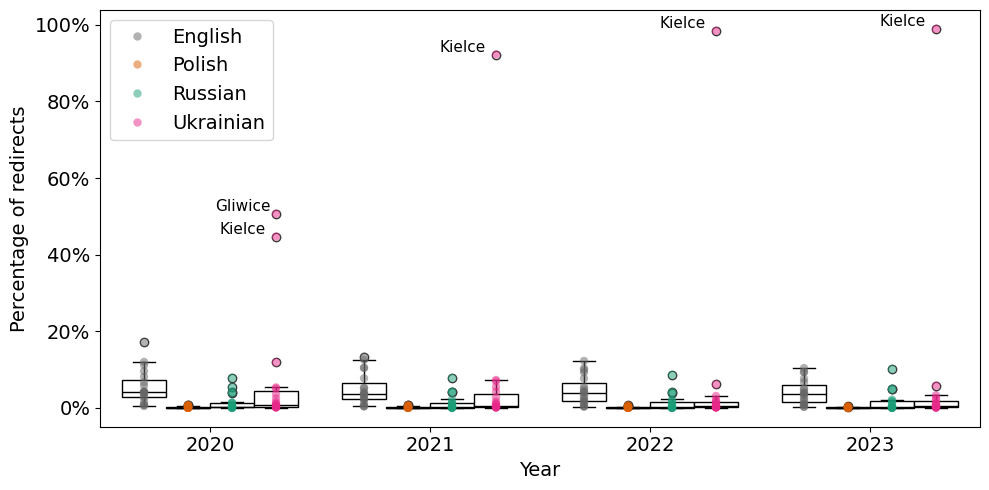

In [14]:
df_yearly = compute_redirect_share_yearly(df_all_pageviews_only, df_all_pageviews_with_redirect)
df_yearly =df_yearly  = df_yearly[df_yearly["Year"].isin(range(2020, 2024))]
plot_redirect_share_by_year_language(df_yearly)

In [15]:
df_yearly.describe()

,Year,views_only,views_with_redirects,Percentage of redirects
count,304.000000,3.040000e+02,3.040000e+02,304.000000
mean,2021.500000,1.695058e+05,1.747932e+05,3.162009
std,1.119877,2.041110e+05,2.127141e+05,10.488391
min,2020.000000,1.260000e+02,3.261000e+03,0.000000
25%,2020.750000,3.309475e+04,3.358800e+04,0.063672
50%,2021.500000,1.049270e+05,1.080670e+05,0.388622
75%,2022.250000,2.320752e+05,2.389528e+05,3.123349
max,2023.000000,1.138853e+06,1.182474e+06,98.938947


In [19]:
df_yearly[["Language", "Percentage of redirects"]].groupby("Language").describe()

Percentage of redirects                                           \
                            count      mean        std       min       25%   
Language                                                                     
English                      76.0  4.741295   3.823337  0.223507  1.692272   
Polish                       76.0  0.122170   0.196811  0.000000  0.006659   
Russian                      76.0  1.335113   2.230697  0.000000  0.057205   
Ukrainian                    76.0  6.449457  19.964175  0.028261  0.169788   

                                          
                50%       75%        max  
Language                                  
English    3.873252  6.921187  17.070821  
Polish     0.030270  0.142557   0.764150  
Russian    0.188561  1.417275  10.113586  
Ukrainian  0.545786  2.476778  98.938947

In [16]:
df_yearly[df_yearly["Percentage of redirects"] >= 20]

,Source,Language,Year,views_only,views_with_redirects,Percentage of redirects
258,Gliwice,Ukrainian,2020,2292,4646,50.667241
346,Kielce,Ukrainian,2020,2944,5324,44.703231
347,Kielce,Ukrainian,2021,421,5441,92.262452
348,Kielce,Ukrainian,2022,169,10758,98.429076
349,Kielce,Ukrainian,2023,126,11875,98.938947
